In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

2023-09-20 17:35:17.603025: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-20 17:35:17.638513: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-20 17:35:17.639034: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 17:35:18.492397: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)
df.head(1)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.4,-8.9,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3


In [4]:
# start from 5 (an hour)
# take every 6th
# so we have hourly data
df = df[5::6]
df.head(2)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3


In [5]:
# change index
# format = means current format present in the data
df.index = pd.to_datetime(df["Date Time"], format = "%d.%m.%Y %H:%M:%S")
df.head(2)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3


In [6]:
df = df["T (degC)"]
df.head()

Date Time
2009-01-01 01:00:00   -8.05
2009-01-01 02:00:00   -8.88
2009-01-01 03:00:00   -8.81
2009-01-01 04:00:00   -9.05
2009-01-01 05:00:00   -9.63
Name: T (degC), dtype: float64

<Axes: xlabel='Date Time'>

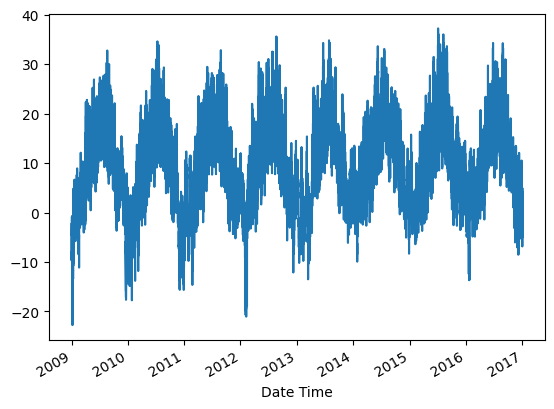

In [7]:
df.plot()# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]


In [8]:
# data after sequencing would look like this - 
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

In [14]:
def df_to_X_y(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        # to make a list of list
        row = [[a] for a in df_as_np[i:i+5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)

    return np.array(X), np.array(y)

In [16]:
X, y = df_to_X_y(df, 5)
X.shape, y.shape

((70086, 5, 1), (70086,))

In [18]:
# can do shuffle = false
X_train, y_train = X[:60000], y[:60000]
X_val, y_val = X[60000:65000], y[60000:65000]
X_test, y_test = X[65000:], y[65000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5086, 5, 1), (5086,))

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [20]:
model = Sequential()
model.add(InputLayer((5,1)))
model.add(LSTM(64))
model.add(Dense(8, "relu"))
model.add(Dense(1, "linear"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
model_check_point = ModelCheckpoint("model/", save_best_only = True)
model.compile(loss = MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [23]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 50, callbacks=[model_check_point])

Epoch 1/50
 115/1875 [>.............................] - ETA: 3s - loss: 0.6839 - root_mean_squared_error: 0.8270

1875/1875 [==============================] - 4s 2ms/step - loss: 0.6474 - root_mean_squared_error: 0.8046 - val_loss: 0.4914 - val_root_mean_squared_error: 0.7010
Epoch 2/50
1867/1875 [============================>.] - ETA: 0s - loss: 0.6442 - root_mean_squared_error: 0.8026INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1875/1875 [==============================] - 6s 3ms/step - loss: 0.6444 - root_mean_squared_error: 0.8027 - val_loss: 0.4874 - val_root_mean_squared_error: 0.6981
Epoch 3/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6423 - root_mean_squared_error: 0.8014 - val_loss: 0.4952 - val_root_mean_squared_error: 0.7037
Epoch 4/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6412 - root_mean_squared_error: 0.8008 - val_loss: 0.4996 - val_root_mean_squared_error: 0.7068
Epoch 5/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.6400 - root_mean_squared_error: 0.8000 - val_loss: 0.4978 - val_root_mean_squared_error: 0.7055
Epoch 6/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6387 - root_mean_squared_error: 0.7992 - val_loss: 0.4895 - val_root_mean_squared_error: 0.6996
Epoch 7/50
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6378 - root_mean_squared_error: 0.7986 - val_loss: 0.4885 - val

INFO:tensorflow:Assets written to: model/assets


1875/1875 [==============================] - 6s 3ms/step - loss: 0.6307 - root_mean_squared_error: 0.7942 - val_loss: 0.4864 - val_root_mean_squared_error: 0.6974
Epoch 23/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6304 - root_mean_squared_error: 0.7940 - val_loss: 0.4949 - val_root_mean_squared_error: 0.7035
Epoch 24/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6309 - root_mean_squared_error: 0.7943 - val_loss: 0.4873 - val_root_mean_squared_error: 0.6980
Epoch 25/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6302 - root_mean_squared_error: 0.7939 - val_loss: 0.4896 - val_root_mean_squared_error: 0.6997
Epoch 26/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6308 - root_mean_squared_error: 0.7942 - val_loss: 0.4902 - val_root_mean_squared_error: 0.7002
Epoch 27/50
1871/1875 [============================>.] - ETA: 0s - loss: 0.6299 - root_mean_squared_error: 0.7936INFO:tensorflow:Assets w

INFO:tensorflow:Assets written to: model/assets


1875/1875 [==============================] - 6s 3ms/step - loss: 0.6299 - root_mean_squared_error: 0.7937 - val_loss: 0.4858 - val_root_mean_squared_error: 0.6970
Epoch 28/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6295 - root_mean_squared_error: 0.7934 - val_loss: 0.4927 - val_root_mean_squared_error: 0.7019
Epoch 29/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6290 - root_mean_squared_error: 0.7931 - val_loss: 0.4860 - val_root_mean_squared_error: 0.6971
Epoch 30/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6298 - root_mean_squared_error: 0.7936 - val_loss: 0.5000 - val_root_mean_squared_error: 0.7071
Epoch 31/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6302 - root_mean_squared_error: 0.7939 - val_loss: 0.4885 - val_root_mean_squared_error: 0.6989
Epoch 32/50
1864/1875 [============================>.] - ETA: 0s - loss: 0.6289 - root_mean_squared_error: 0.7930INFO:tensorflow:Assets w

INFO:tensorflow:Assets written to: model/assets


1875/1875 [==============================] - 6s 3ms/step - loss: 0.6297 - root_mean_squared_error: 0.7935 - val_loss: 0.4847 - val_root_mean_squared_error: 0.6962
Epoch 33/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6293 - root_mean_squared_error: 0.7933 - val_loss: 0.5002 - val_root_mean_squared_error: 0.7072
Epoch 34/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6299 - root_mean_squared_error: 0.7937 - val_loss: 0.4909 - val_root_mean_squared_error: 0.7006
Epoch 35/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6286 - root_mean_squared_error: 0.7929 - val_loss: 0.4850 - val_root_mean_squared_error: 0.6964
Epoch 36/50
1862/1875 [============================>.] - ETA: 0s - loss: 0.6285 - root_mean_squared_error: 0.7928INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1875/1875 [==============================] - 6s 3ms/step - loss: 0.6286 - root_mean_squared_error: 0.7928 - val_loss: 0.4840 - val_root_mean_squared_error: 0.6957
Epoch 37/50
1863/1875 [============================>.] - ETA: 0s - loss: 0.6297 - root_mean_squared_error: 0.7935INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1875/1875 [==============================] - 7s 3ms/step - loss: 0.6286 - root_mean_squared_error: 0.7928 - val_loss: 0.4827 - val_root_mean_squared_error: 0.6948
Epoch 38/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6276 - root_mean_squared_error: 0.7922 - val_loss: 0.4838 - val_root_mean_squared_error: 0.6956
Epoch 39/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6284 - root_mean_squared_error: 0.7927 - val_loss: 0.5022 - val_root_mean_squared_error: 0.7087
Epoch 40/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6287 - root_mean_squared_error: 0.7929 - val_loss: 0.5017 - val_root_mean_squared_error: 0.7083
Epoch 41/50
1871/1875 [============================>.] - ETA: 0s - loss: 0.6278 - root_mean_squared_error: 0.7924INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1875/1875 [==============================] - 6s 3ms/step - loss: 0.6277 - root_mean_squared_error: 0.7923 - val_loss: 0.4818 - val_root_mean_squared_error: 0.6941
Epoch 42/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6275 - root_mean_squared_error: 0.7922 - val_loss: 0.4852 - val_root_mean_squared_error: 0.6966
Epoch 43/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6273 - root_mean_squared_error: 0.7920 - val_loss: 0.4892 - val_root_mean_squared_error: 0.6994
Epoch 44/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6273 - root_mean_squared_error: 0.7921 - val_loss: 0.4877 - val_root_mean_squared_error: 0.6983
Epoch 45/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6270 - root_mean_squared_error: 0.7918 - val_loss: 0.4988 - val_root_mean_squared_error: 0.7062
Epoch 46/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6269 - root_mean_squared_error: 0.7918 - val_loss: 0.4877 

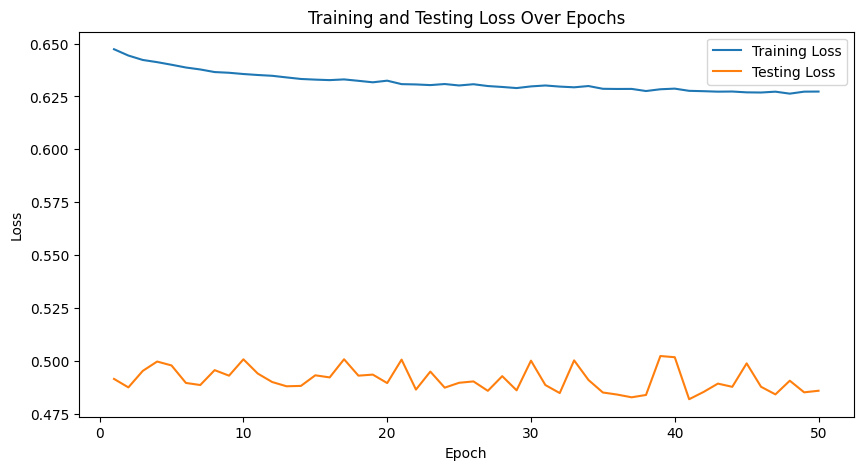

In [25]:
import matplotlib.pyplot as plt

training_loss = history.history['loss']
testing_loss = history.history['val_loss']

epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, testing_loss, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()

In [27]:
from tensorflow.keras.models import load_model
model = load_model('model/')

In [34]:
train_predictions = model.predict(X_test).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results

  1/159 [..............................] - ETA: 41s

159/159 [==============================] - 0s 1ms/step


,Train Predictions,Actuals
0,14.312967,13.99
1,13.160909,13.46
2,12.861508,12.93
3,12.433609,12.43
4,12.012330,12.17
...,...,...
5081,-0.866391,-0.98
5082,-1.335984,-1.40
5083,-1.629893,-2.75
5084,-3.174899,-2.89


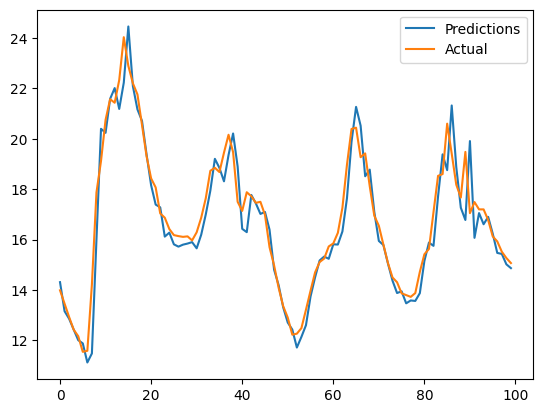

In [35]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][:100], label = "Predictions")
plt.plot(train_results['Actuals'][:100], label = "Actual")
plt.legend()
plt.show()

In [36]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

159/159 [==============================] - 0s 1ms/step
Root Mean Squared Error (RMSE): 0.7844860193818997
